In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import yaml  # If not installed: pip install pyyaml

# Set up algorithm colors
colors = {
    "DQN": 'darkorange',
    "PPO": 'forestgreen',
    "CMA": 'cyan',
    "ODT": 'blueviolet'
}

# Helper functions
def load_config_file(filepath):
    with open(filepath, 'r') as f:
        return yaml.safe_load(f)

def read_csv_data(filepath, columns):
    return pd.read_csv(filepath, usecols=columns)


In [25]:
# Define experiment range and chunk size
starting_exp = 6108
ending_exp = 6111
chunk_size = 3

all_experiments = list(range(starting_exp, ending_exp + 1))
experiment_chunks = [all_experiments[i:i + chunk_size] for i in range(0, len(all_experiments), chunk_size)]
save_processed_data = True
file_path_for_processed_data = './processed_data'

for chunk in experiment_chunks:
    exp_agent_data = []
    
    for exp_num in chunk:
        config_fname = f'./Exp_{exp_num}/config.yaml'
        c = load_config_file(config_fname)
        nn_c = c['nn_hyperparameters']
        federated_c = c['federated_learning_settings']
        algo_c = c['algorithm_settings']
        env_c = c['environment_settings']
        cma_c = c['cma_parameters']
    
        seed = env_c['seed']
        algorithm_dm = algo_c['algorithm']

        def load_from_json_with_error_handling(filepath, columns_specific):
            try:
                return read_csv_data(filepath, columns=columns_specific)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON from {filepath}: {e.msg} at line {e.lineno}, column {e.colno}")
                return None
    
        path_list = [
            f"/storage_1/epigou_storage/Exp_{exp_num}"
        ]
    
        d_base = next((p for p in path_list if os.path.exists(p)), None)
        if d_base is None:
            print(f"Data folder not found for experiment {exp_num}; skipping.")
            continue

        base_path = f"{d_base}/train/metrics"
        print(f'Loading {base_path}_agent_metrics.csv for experiment {exp_num}')
        agent_data = load_from_json_with_error_handling(
            f'{base_path}_agent_metrics.csv',
            ['episode', 'timestep', 'done', 'zone', 'aggregation', 'agent_index', 'reward']
        )
        if agent_data is None:
            continue

        agent_data['seed'] = seed
        agent_data['exp_num'] = exp_num
        agent_data['algorithm'] = algorithm_dm
        agent_data['season'] = env_c['season']
        agent_data['num_aggs'] = federated_c['aggregation_count']
        agent_data['eps_per_agg'] = (
            cma_c['max_generations'] if algorithm_dm == 'CMA' else nn_c['num_episodes']
        )

        exp_agent_data.append(agent_data)

    if len(exp_agent_data) == 0:
        continue

    df_agent = pd.concat(exp_agent_data, ignore_index=True)

    cumulative_agent_df = (
        df_agent
        .groupby(
            ['episode', 'zone', 'aggregation', 'agent_index', 'seed', 'exp_num', 'algorithm', 'season', 'num_aggs', 'eps_per_agg']
        )['reward']
        .sum()
        .reset_index()
    )
    cumulative_agent_df.rename(columns={'reward': 'cumulative_reward'}, inplace=True)
    cumulative_agent_df['episode'] = (
        cumulative_agent_df['aggregation'] * cumulative_agent_df['eps_per_agg'] + cumulative_agent_df['episode']
    )

    cumulative_avg_reward_by_algorithm = (
        cumulative_agent_df
        .groupby(['episode', 'algorithm', 'seed', 'num_aggs', 'season', 'eps_per_agg', 'exp_num'])['cumulative_reward']
        .mean()
        .reset_index()
    )

    cumulative_avg_reward_by_algorithm = cumulative_avg_reward_by_algorithm.sort_values(
        ['season', 'algorithm', 'seed', 'num_aggs', 'episode']
    )
    cumulative_avg_reward_by_algorithm['cumulative_reward'] = (
        cumulative_avg_reward_by_algorithm
        .groupby(['algorithm', 'seed', 'num_aggs', 'season'])['cumulative_reward']
        .transform(lambda x: x.expanding().mean())
    )

    if save_processed_data:
        chunk_folder = os.path.join(file_path_for_processed_data, f"{chunk[0]}_{chunk[-1]}")
        os.makedirs(chunk_folder, exist_ok=True)
        csv_path = os.path.join(chunk_folder, f"{chunk[0]}_{chunk[-1]}.csv")
        cumulative_avg_reward_by_algorithm.to_csv(csv_path, index=False)
        print(f"Data successfully saved to {csv_path}")


Loading /storage_1/epigou_storage/Exp_6108/train/metrics_agent_metrics.csv for experiment 6108
Loading /storage_1/epigou_storage/Exp_6109/train/metrics_agent_metrics.csv for experiment 6109
Loading /storage_1/epigou_storage/Exp_6110/train/metrics_agent_metrics.csv for experiment 6110
Data successfully saved to ./processed_data/6108_6110/6108_6110.csv
Loading /storage_1/epigou_storage/Exp_6111/train/metrics_agent_metrics.csv for experiment 6111
Data successfully saved to ./processed_data/6111_6111/6111_6111.csv


In [22]:
for chunk in experiment_chunks:
    chunk_file = os.path.join(file_path_for_processed_data, f"{chunk[0]}_{chunk[-1]}", f"{chunk[0]}_{chunk[-1]}.csv")
    if not os.path.exists(chunk_file):
        print(f"Missing file for chunk {chunk[0]}–{chunk[-1]}; skipping plot.")
        continue

    df = pd.read_csv(chunk_file)
    print(df.head())
    print(df.tail()) 

   episode algorithm  seed  num_aggs  season  eps_per_agg  exp_num  \
0        0       ODT  3702        50  spring           80     6108   
1        1       ODT  3702        50  spring           80     6108   
2        2       ODT  3702        50  spring           80     6108   
3        3       ODT  3702        50  spring           80     6108   
4        4       ODT  3702        50  spring           80     6108   

   cumulative_reward  
0         -91.456127  
1         -91.581157  
2         -91.632562  
3         -91.719352  
4         -91.927506  
       episode algorithm   seed  num_aggs  season  eps_per_agg  exp_num  \
11395     3991       ODT  16665        50  spring           80     6109   
11396     3992       ODT  16665        50  spring           80     6109   
11397     3993       ODT  16665        50  spring           80     6109   
11398     3994       ODT  16665        50  spring           80     6109   
11399     3995       ODT  16665        50  spring           80    

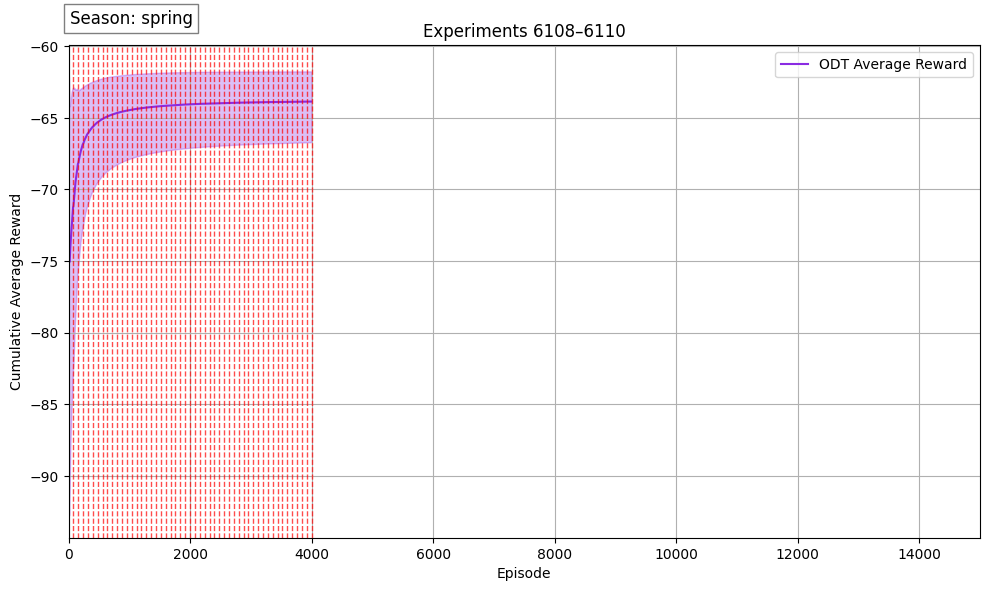

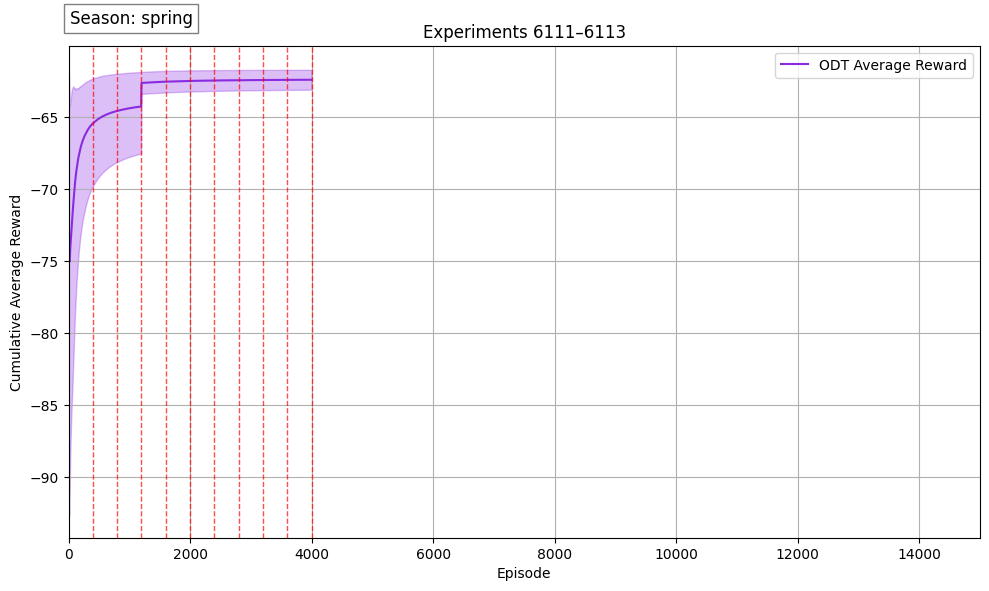

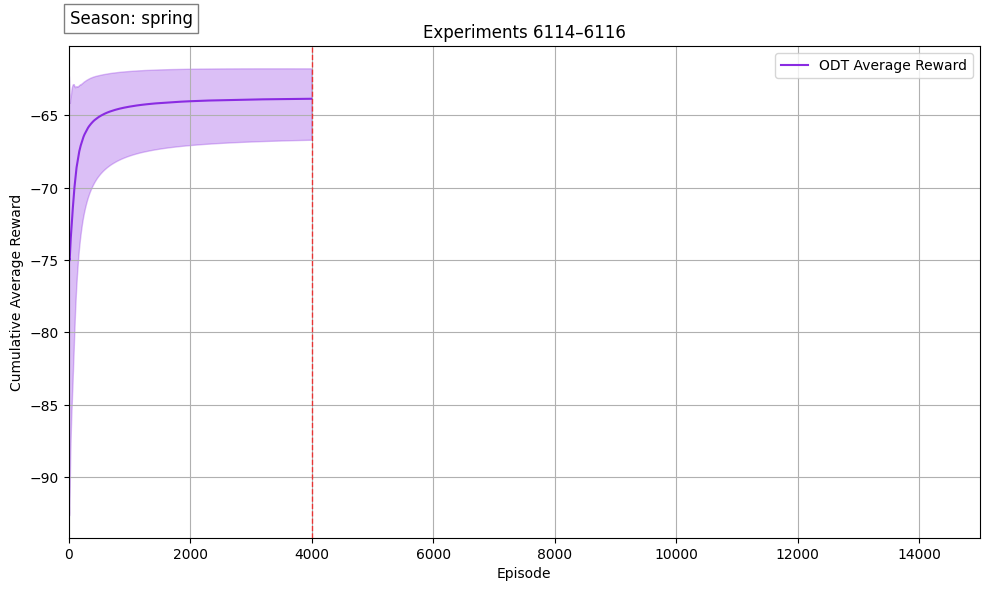

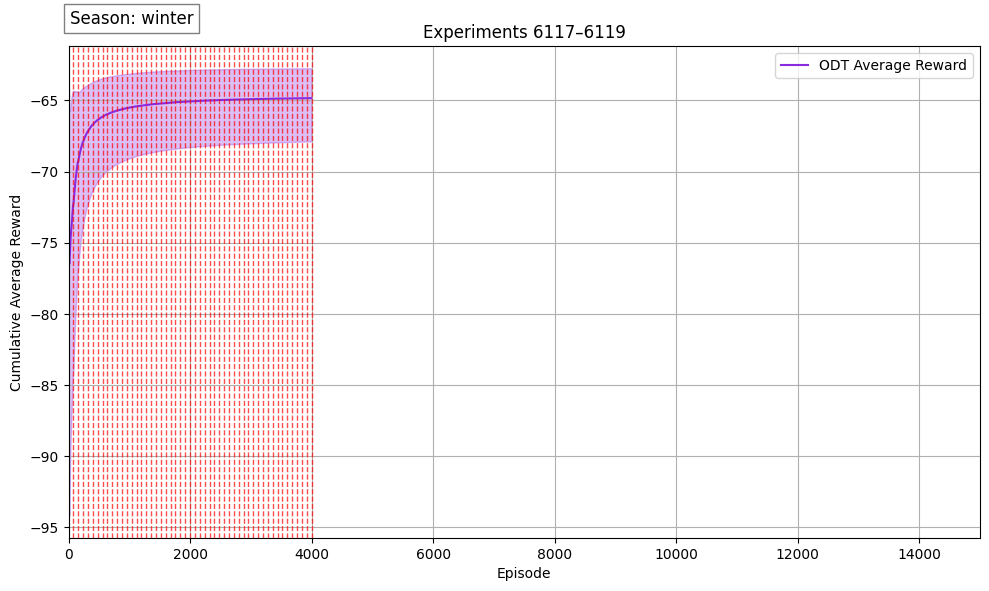

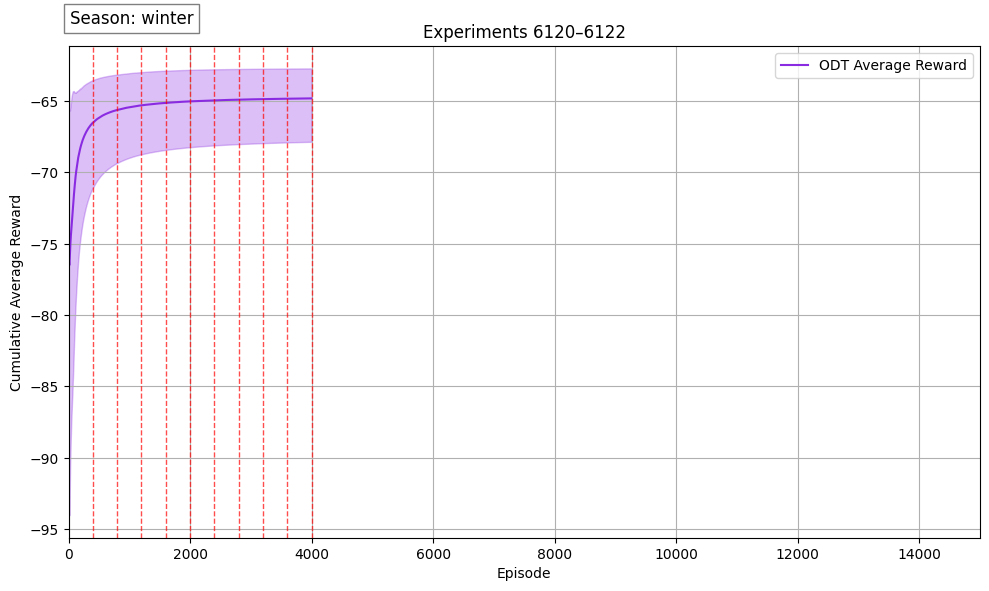

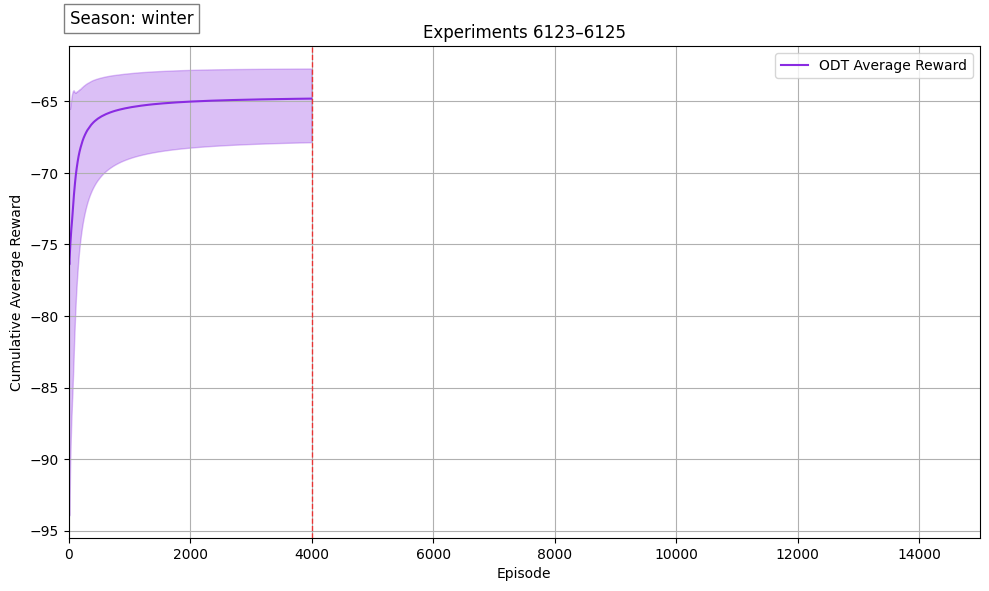

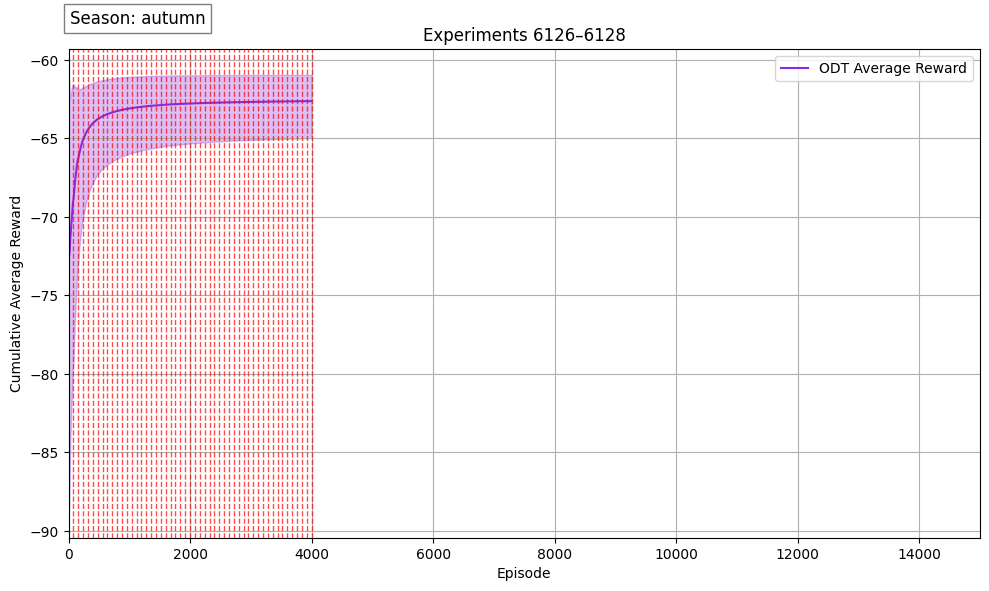

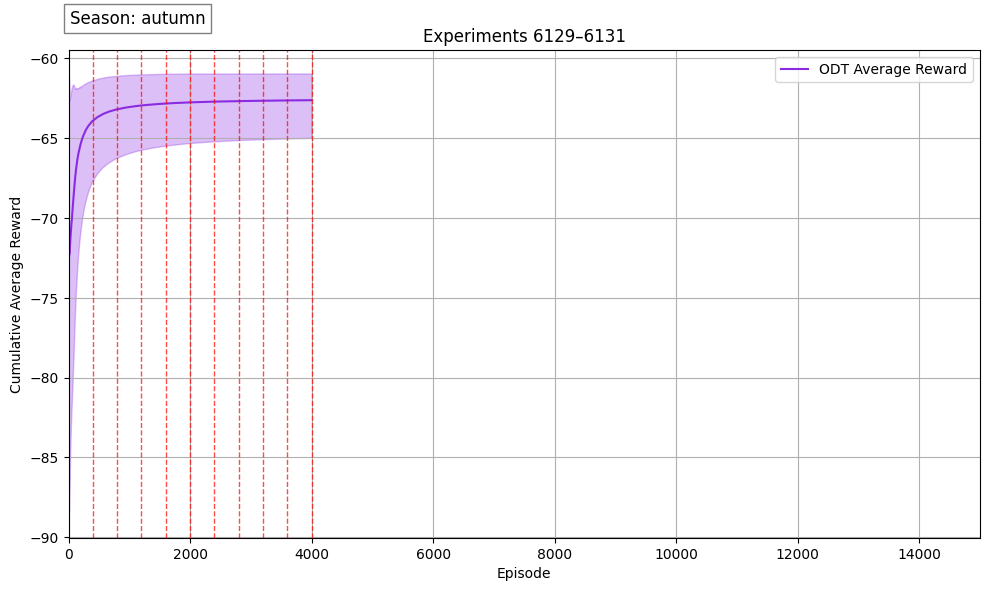

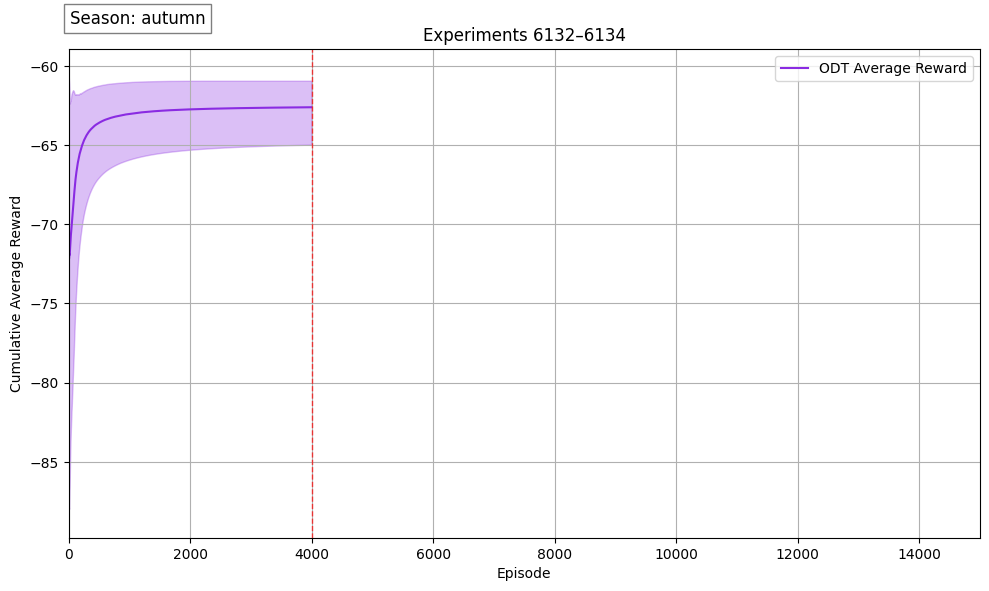

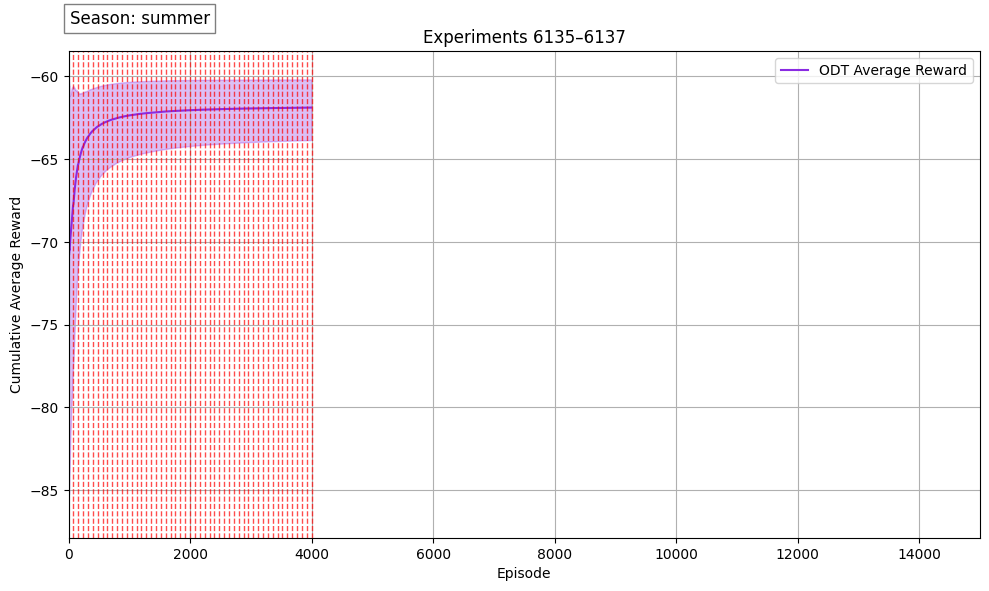

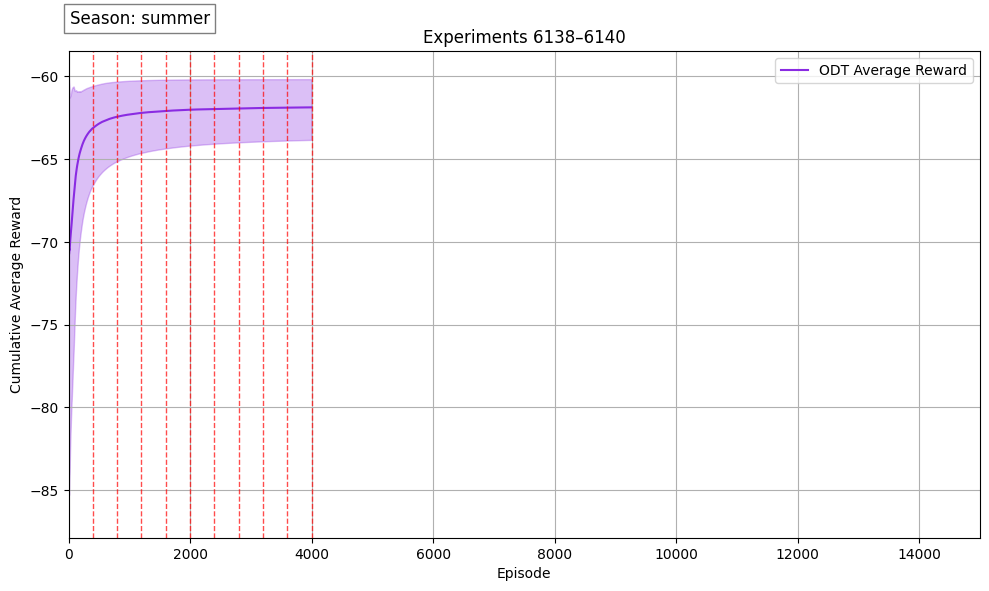

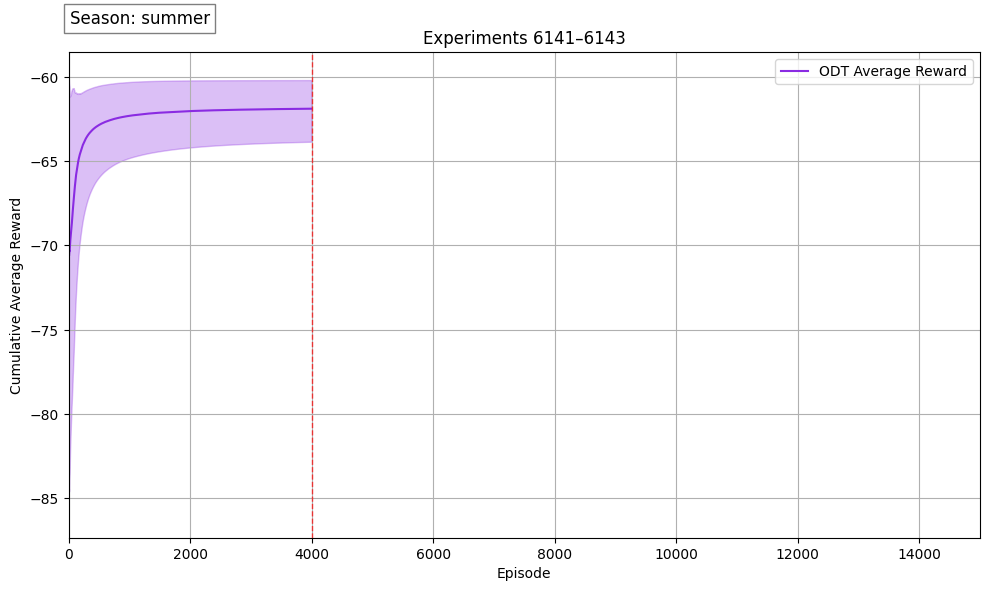

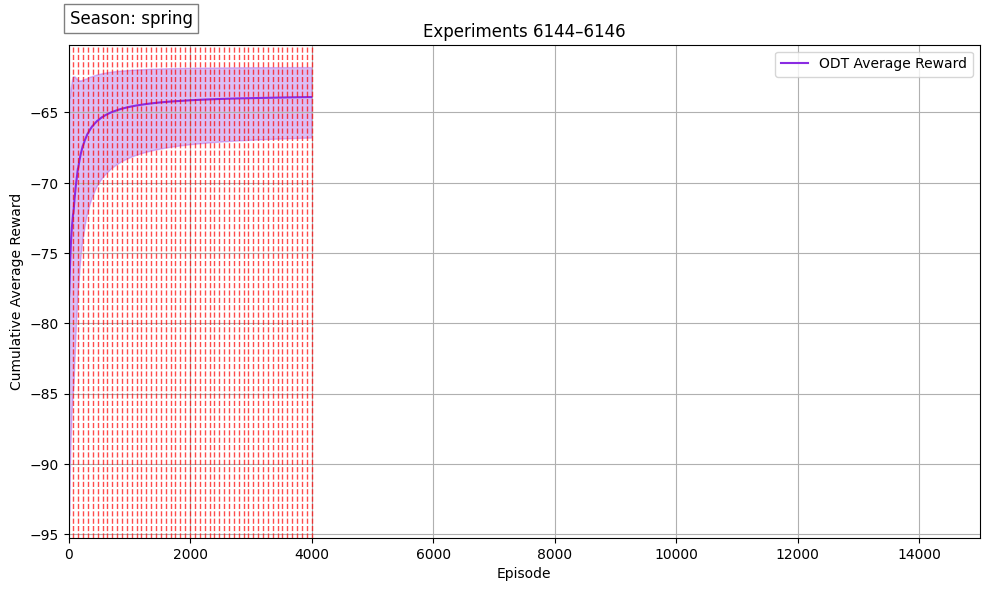

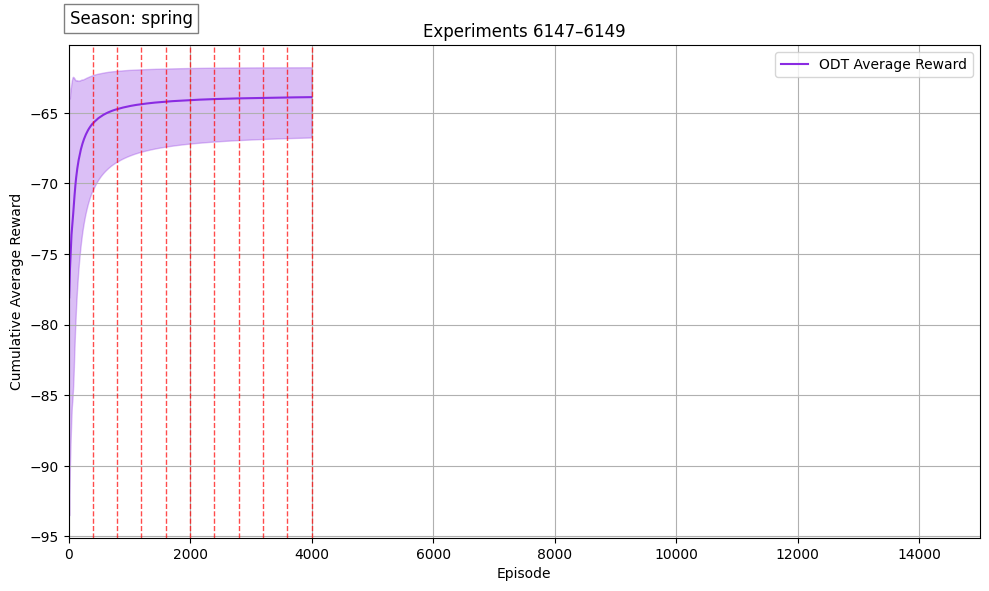

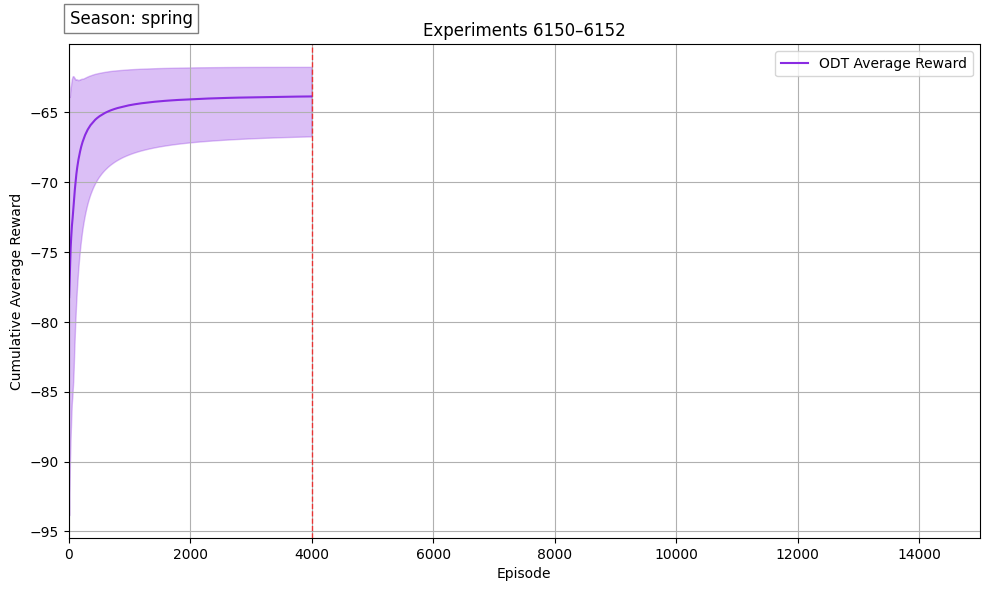

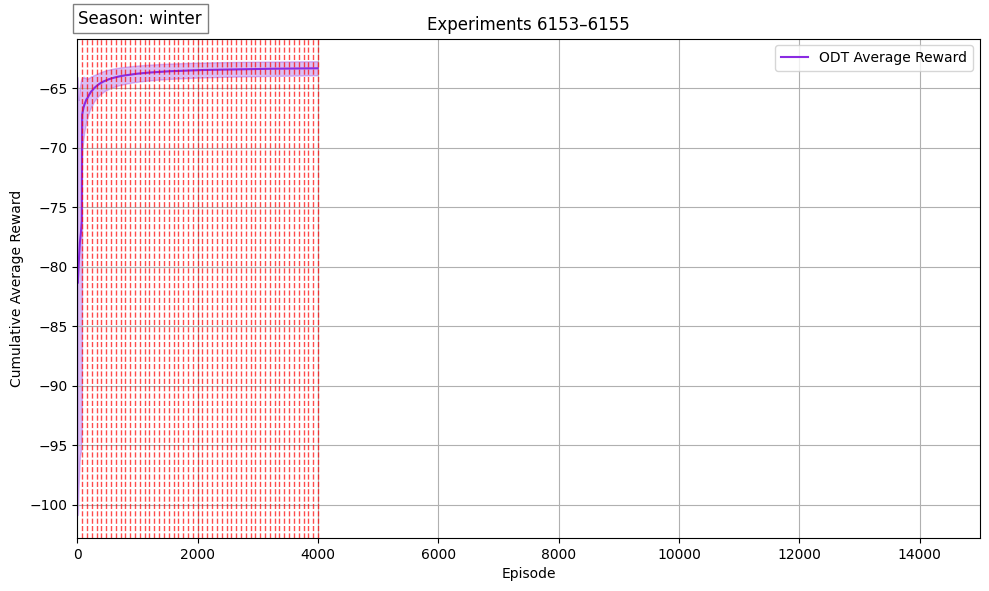

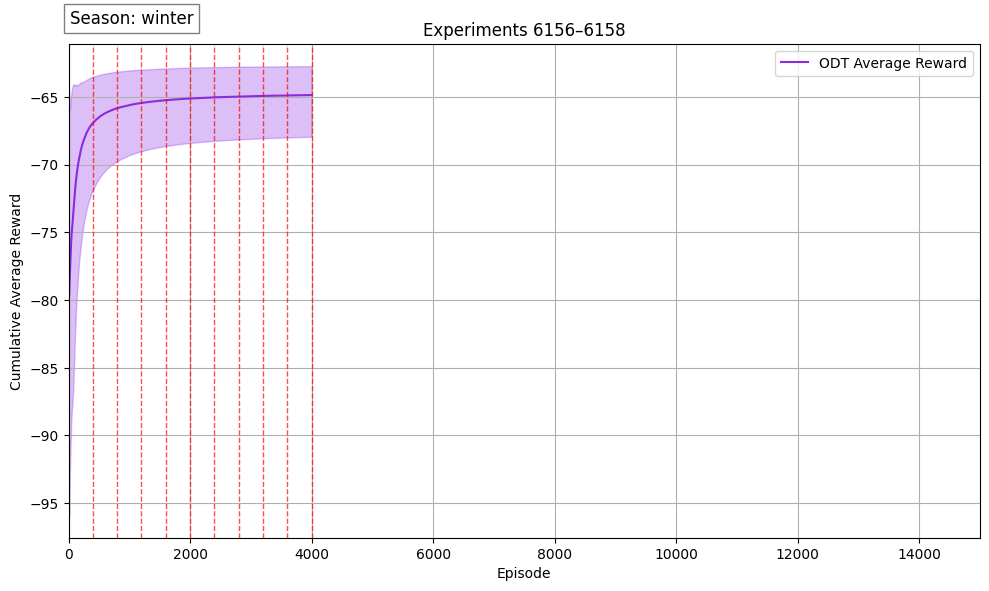

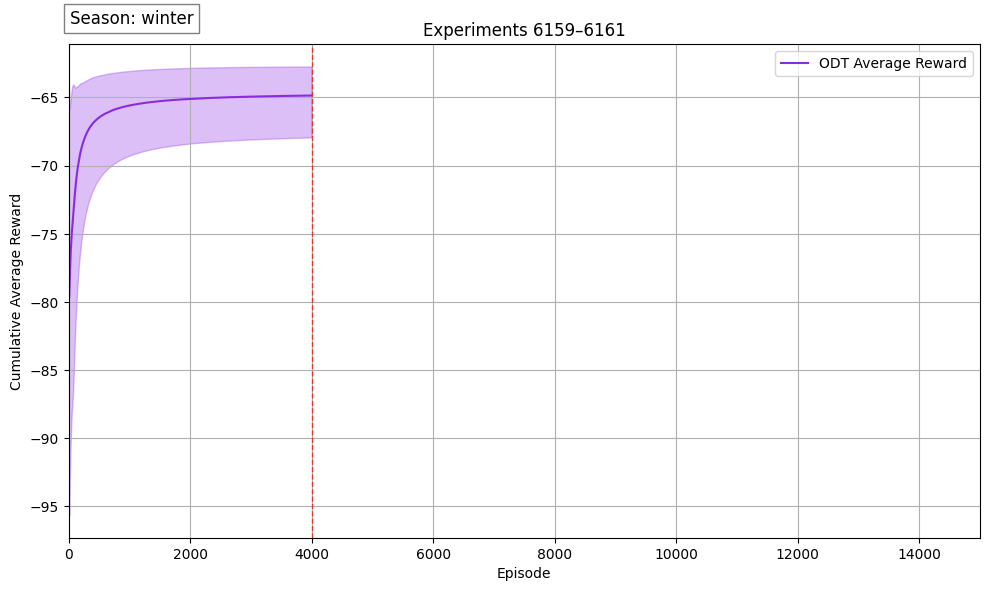

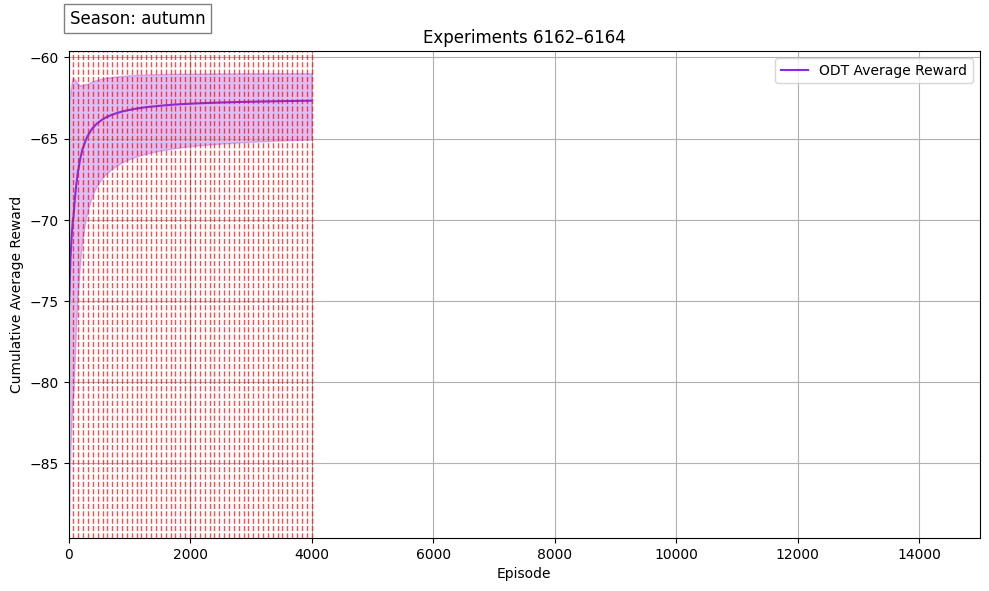

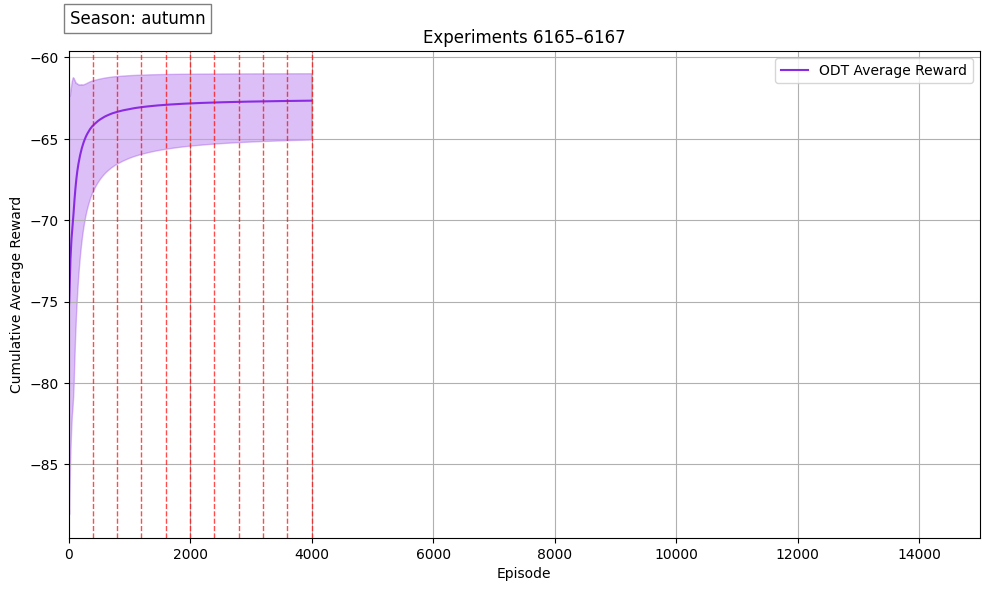

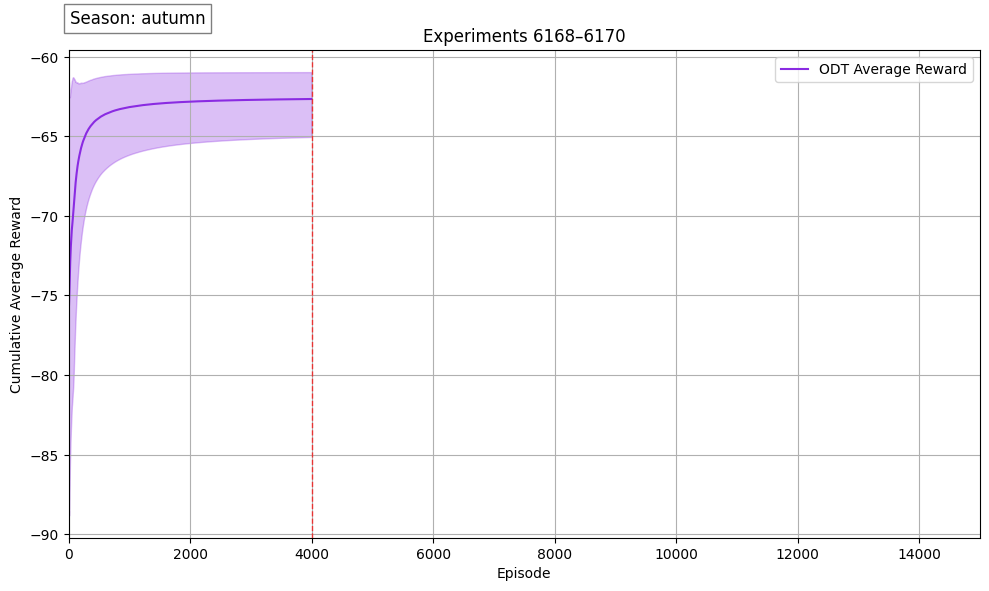

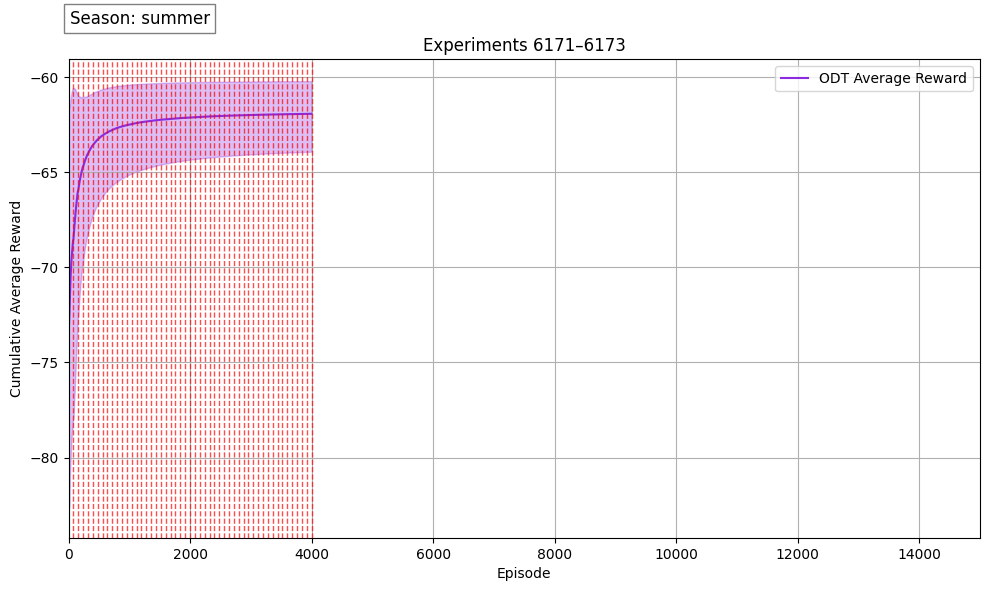

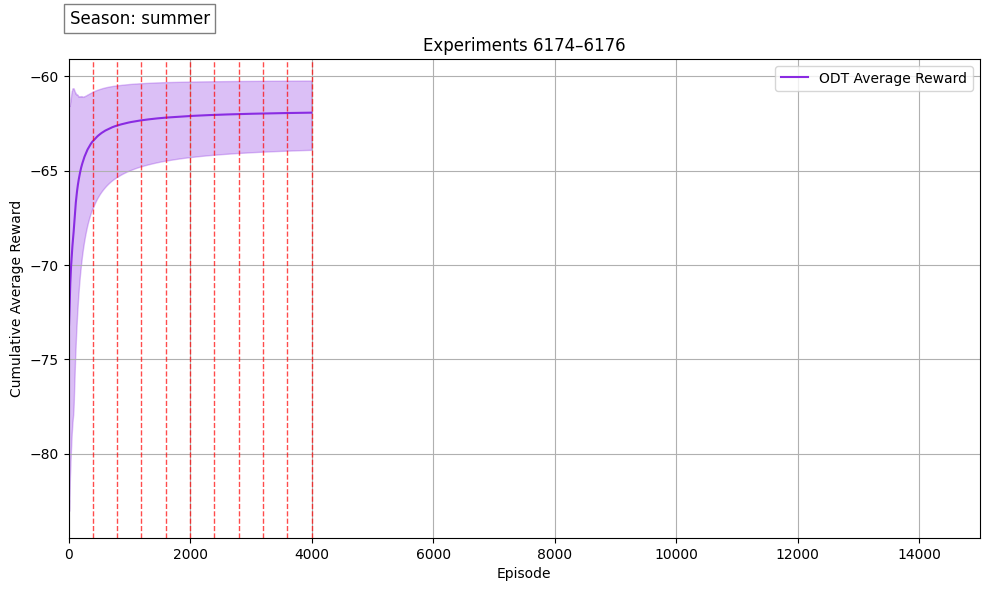

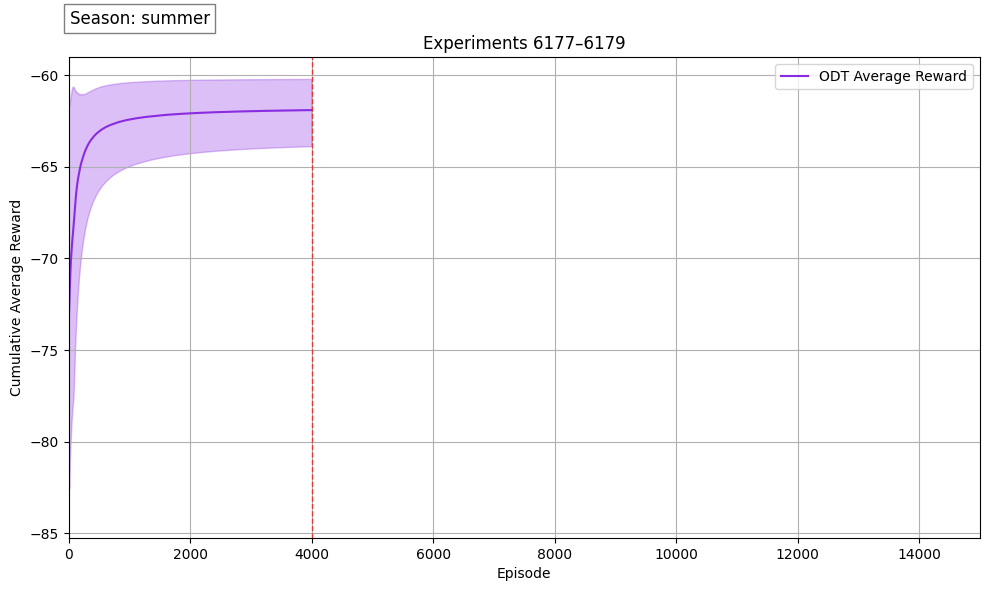

In [23]:
for chunk in experiment_chunks:
    chunk_file = os.path.join(file_path_for_processed_data, f"{chunk[0]}_{chunk[-1]}", f"{chunk[0]}_{chunk[-1]}.csv")
    if not os.path.exists(chunk_file):
        print(f"Missing file for chunk {chunk[0]}–{chunk[-1]}; skipping plot.")
        continue

    df = pd.read_csv(chunk_file)

    # Check for mixed seasons (fall back to 'Mixed' if more than one unique value)
    unique_seasons = df['season'].unique()
    season_label = unique_seasons[0] if len(unique_seasons) == 1 else "Mixed"

    agg_data = (
        df
        .groupby(['episode', 'algorithm'])['cumulative_reward']
        .agg(['mean', 'min', 'max'])
        .reset_index()
    )

    fig, ax = plt.subplots(figsize=(10, 6))

    for algo in agg_data['algorithm'].unique():
        algo_data = agg_data[agg_data['algorithm'] == algo]
        ax.fill_between(
            algo_data['episode'],
            algo_data['min'],
            algo_data['max'],
            color=colors.get(algo, 'gray'),
            alpha=0.3
        )
        ax.plot(
            algo_data['episode'],
            algo_data['mean'],
            color=colors.get(algo, 'gray'),
            label=f'{algo} Average Reward'
        )

    # Estimate eps_per_agg if needed
    if 'eps_per_agg' in df.columns:
        eps_per_agg = df['eps_per_agg'].iloc[0]
    else:
        num_aggs = df['num_aggs'].iloc[0]
        max_episode = df['episode'].max()
        eps_per_agg = int(np.ceil(max_episode / num_aggs))

    num_aggs = df['num_aggs'].iloc[0]
    for agg in range(1, int(num_aggs) + 1):
        ax.axvline(x=agg * eps_per_agg, color='r', linestyle='--', linewidth=1, alpha=0.7)

    # Add season label in top-left corner
    x_pos = df['episode'].min()
    y_pos = df['cumulative_reward'].max() * 0.95
    ax.text(x_pos + 20, y_pos, f"Season: {season_label}", fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    ax.set_xlabel('Episode')
    ax.set_ylabel('Cumulative Average Reward')
    ax.set_title(f'Experiments {chunk[0]}–{chunk[-1]}')
    ax.legend()
    ax.grid(True)
    ax.set_xlim(0, 15000)

    plt.tight_layout()
    plt.show()


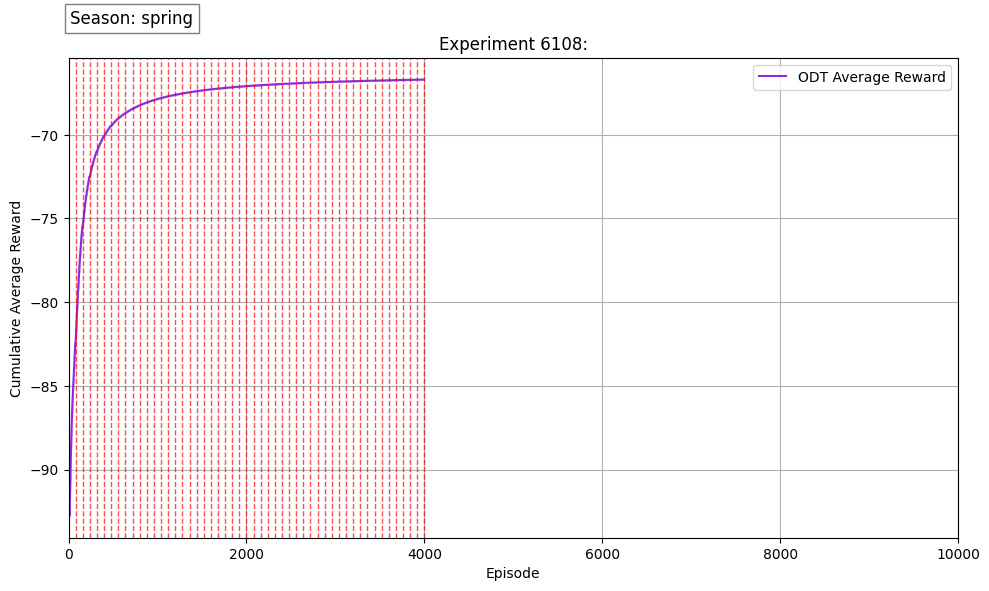

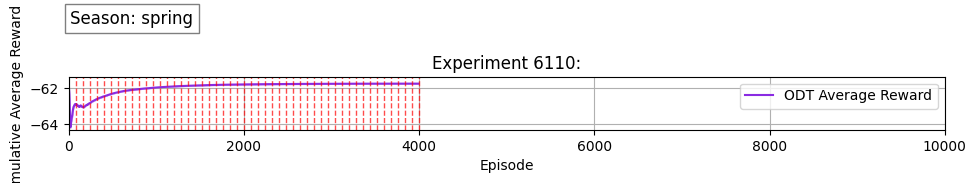

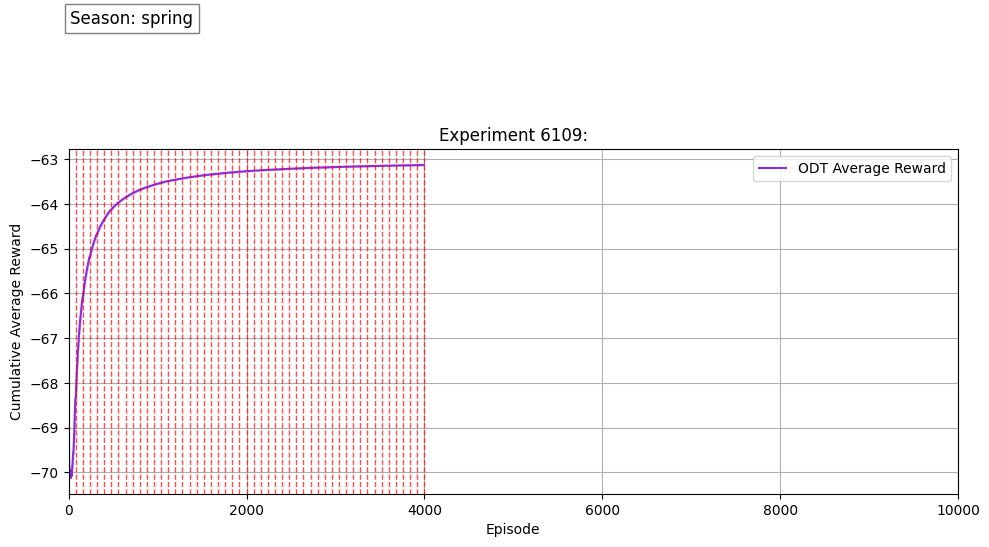


Experiments with fewer than 3 900 episodes (no plots generated):
  • Experiment 6111: only 1195 episodes


In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

missing_chunks = []
under_threshold_experiments = []

for chunk in experiment_chunks:
    chunk_file = os.path.join(
        file_path_for_processed_data,
        f"{chunk[0]}_{chunk[-1]}",
        f"{chunk[0]}_{chunk[-1]}.csv"
    )
    if not os.path.exists(chunk_file):
        missing_chunks.append(f"{chunk[0]}–{chunk[-1]}")
        continue

    df_chunk = pd.read_csv(chunk_file)

    for exp_num in df_chunk['exp_num'].unique():
        df = df_chunk[df_chunk['exp_num'] == exp_num]
        max_episode = df['episode'].max()

        # If an experiment has fewer than 3 900 episodes, record and skip plotting
        if max_episode < 3900:
            under_threshold_experiments.append((exp_num, max_episode))
            continue

        # … otherwise do your plotting as before …
        unique_seasons = df['season'].unique()
        season_label = unique_seasons[0] if len(unique_seasons) == 1 else "Mixed"

        agg_data = (
            df
            .groupby(['episode', 'algorithm'])['cumulative_reward']
            .agg(['mean', 'min', 'max'])
            .reset_index()
        )

        fig, ax = plt.subplots(figsize=(10, 6))
        for algo in agg_data['algorithm'].unique():
            algo_data = agg_data[agg_data['algorithm'] == algo]
            ax.fill_between(
                algo_data['episode'],
                algo_data['min'],
                algo_data['max'],
                color=colors.get(algo, 'gray'),
                alpha=0.3
            )
            ax.plot(
                algo_data['episode'],
                algo_data['mean'],
                color=colors.get(algo, 'gray'),
                label=f'{algo} Average Reward'
            )

        eps_per_agg = (
            df['eps_per_agg'].iloc[0]
            if 'eps_per_agg' in df.columns
            else int(np.ceil(df['episode'].max() / df['num_aggs'].iloc[0]))
        )
        for agg in range(1, int(df['num_aggs'].iloc[0]) + 1):
            ax.axvline(
                x=agg * eps_per_agg,
                color='r',
                linestyle='--',
                linewidth=1,
                alpha=0.7
            )

        ax.text(
            20,
            df['cumulative_reward'].max() * 0.95,
            f"Season: {season_label}",
            fontsize=12,
            bbox=dict(facecolor='white', alpha=0.5)
        )
        ax.set_xlabel('Episode')
        ax.set_ylabel('Cumulative Average Reward')
        ax.set_title(f'Experiment {exp_num}:')
        ax.legend()
        ax.grid(True)
        ax.set_xlim(0, 10000)
        plt.tight_layout()
        plt.show()

# After all chunks are processed, print summaries:
if missing_chunks:
    print("\nMissing files for these chunks (skipped entirely):")
    for rng in missing_chunks:
        print(f"  • {rng}")

if under_threshold_experiments:
    print("\nExperiments with fewer than 3 900 episodes (no plots generated):")
    for exp_num, max_ep in under_threshold_experiments:
        print(f"  • Experiment {exp_num}: only {max_ep} episodes")
